In [1]:
import copy
import os
import random

from PIL import Image

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler 
from torchvision import transforms

import numpy as np

import pandas as pd

In [2]:
TRAIN_IMAGES_PATH = os.sep.join(["..", "resized_images"]) # относительный путь к папке с картинками
CSV_PATH = "sample_full.csv"
IMAGE_NORMAL_SIZE = (224, 224)
RANDOM_SEED = 4545435
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CPU = torch.device("cpu")

print("Using", DEVICE, "for neural network training.")

Using cuda for neural network training.


In [3]:
MODEL_NAME = "resnet"
NUM_LAYERS = 8
GRAM = True
N_FEATURES = 512*512 if GRAM else 512
MAX_FEATURES = 16000
NUM_CLASSES = 13
ENABLE_PCA = True
PCA_COMPONENTS = 8000

In [4]:
class MyCustomDataset(Dataset):
    def __init__(self, dict_path):
        self.transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.class_dict = pd.read_csv(dict_path)
        
    def __getitem__(self, index):
        row = self.class_dict.iloc[index]
        file_path = row[1]
        data = Image.open(file_path).convert("RGB").resize(IMAGE_NORMAL_SIZE)
        data = self.transformations(data)  # (3)
        label = row[2]
        return data, label

    def __len__(self):
        return self.class_dict.index.shape[0]
    

class StyleMatrix(nn.Module):
    def __init__(self):
        super(StyleMatrix, self).__init__()

    def forward(self, input_):
         return __class__.gram_matrix(input_)
    
    @staticmethod
    def gram_matrix(inp): # исправленная версия
        a, b, c, d = inp.size()
        # a=batch size(=1)
        # b=number of feature maps
        # (c, d) = dimensions of a f. map (N=c*d)
        features = inp.view(a, b, c * d)  # resise F_XL into \hat F_XL
        G = torch.empty((a, b, b))
        for i in range(a):
            G[i] = torch.mm(features[i], features[i].t())
        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

## Создание списка всех изображений (номер - путь к файлу - класс) 
### Аргументы:  
**file_path**-название результирующего файла,  
**cut_factor**-как "порезать" датасет (cut_factor=2 будет выбирать только каждую 2 картинку.  
Чем больше cut_factor-тем меньше датасет, выбрать полный датасет-cut_factor=1)

In [5]:
def generate_csv_classes(file_path, cut_factor=1):
    header = "filename,full_filename,num_class"
    data = header + "\n"
    
    timeframes = os.listdir(TRAIN_IMAGES_PATH)
    
    with open(file_path, "w+") as file_csv:
        for count_class, timeframe in enumerate(timeframes):
            timeframe_images_path = TRAIN_IMAGES_PATH+ os.sep + timeframe
            images = os.listdir(timeframe_images_path)
            img_count = 0
            for image_name in images:
                img_count+=1
                if img_count % cut_factor == 0: 
                    image_index = image_name.split(".")[0]
                    image_path = timeframe_images_path + os.sep + image_name
                    count_class_this = "0" if count_class <= 16 else str(count_class-16)
                    data += "{},{},{}\n".format(image_index, image_path, count_class_this)
                
        file_csv.write(data)
        
CUT_FACTOR = 1
generate_csv_classes(CSV_PATH, cut_factor=CUT_FACTOR)

## Загрузчики данных

In [6]:
VALIDATION_SPLIT = 0.4
TEST_SPLIT = 0.5
BATCH_SIZE = 5

In [7]:
data = MyCustomDataset(CSV_PATH)

dataset_size = len(data) 
indices = list(range(dataset_size)) 

split = int(VALIDATION_SPLIT * dataset_size)

np.random.seed(RANDOM_SEED) 
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices) 
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(data, batch_size=BATCH_SIZE, num_workers=0, sampler=train_sampler)

val_loader = DataLoader(data, batch_size=BATCH_SIZE, num_workers=0, sampler=valid_sampler)

print("Number of batches in train loader: {} ({} images)".format(len(train_loader), len(train_loader) * BATCH_SIZE))
print("Number of batches in validation loader: {} ({} images)".format(len(val_loader), len(val_loader) * BATCH_SIZE))

Number of batches in train loader: 3747 (18735 images)
Number of batches in validation loader: 2498 (12490 images)


In [8]:
N_BATCHES = len(train_loader)

In [9]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}

## Вспомогательные функции

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            index = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if (100 * index // len(dataloaders[phase])) // 10 != (100 * (index - 1) // len(dataloaders[phase])) // 10:
                    print('=', end='')
                index += 1

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('\t{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

## Инициализация и обучение модели

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
def initialize_model(model_name, num_classes, feature_extract=True, add_gram=False, n_layers=None,
                     use_pretrained=True, classifier=None):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        if n_layers is not None:
            if add_gram == False:
                model_ft = nn.Sequential(*list(model_ft.children())[:n_layers])
            else:
                model_ft = nn.Sequential(*(list(model_ft.children())[:n_layers]) + [StyleMatrix()])
        if classifier is not None:
            model_ft = nn.Sequential(*(list(model_ft.children())) + [classifier])

    elif model_name == "vgg19_bn":
        """ VGG-19 with batch normalization 
        """
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        if n_layers is not None:
            if add_gram == False:
                model_ft = nn.Sequential(*list(model_ft.features.children())[:n_layers])
            else:
                model_ft = nn.Sequential(*(list(model_ft.features.children())[:n_layers]) + [StyleMatrix()])
        if classifier is not None:
            model_ft.classifier = classifier
        
    elif model_name == "vgg19":
        """ VGG-19 
        """
        model_ft = models.vgg19(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        if n_layers is not None:
            if add_gram == False:
                model_ft = nn.Sequential(*list(model_ft.features.children())[:n_layers])
            else:
                model_ft = nn.Sequential(*(list(model_ft.features.children())[:n_layers]) + [StyleMatrix()])
        if classifier is not None:
            model_ft.classifier = classifier
                
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft.to(DEVICE), input_size

# Initialize the model for this run
# Only n_layers from features will be taken, all of them if n_layers=None
network, input_size = initialize_model(model_name=MODEL_NAME, num_classes=NUM_CLASSES, n_layers=NUM_LAYERS, add_gram = GRAM)

# Print the model we just instantiated
network.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [13]:
params_to_update = []
for name, param in network.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

In [14]:
if params_to_update:
    model_ft, hist = train_model(network, dataloaders_dict,
                                 optimizer=torch.optim.SGD(params_to_update, lr=0.01, momentum=0.9),
                                 criterion=nn.CrossEntropyLoss(), num_epochs=10)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

if params_to_update:
    sns.set()
    plt.plot(hist)

## Отбор признаков (можно пропустить)
Каждую итерацию исключается ровно половина признаков, выявление наиболее важных происходит на 500, 1000, ... объектах в зависимости от текущего количества неисключенных признаков. В конце остаётся ~4000, которые можно сохранить в csv или продолжить работу.


In [16]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

def select_features(loader, model, mask, n_batches, k):
    X = []
    y = []
    for i, (images, labels) in enumerate(loader):
        if i > n_batches:
            break
        actual_batch_size = min(images.shape[0], BATCH_SIZE)
        G_matrices = model(torch.reshape(images, (actual_batch_size, 3, *IMAGE_NORMAL_SIZE)).to(DEVICE))
        for j in range(actual_batch_size):
            X.append((G_matrices[j].cpu().detach().numpy().reshape(1, N_FEATURES))[0][mask])
        y += labels.tolist()
        if (i % 500) == 0:
            print(i, "batches out of", n_batches, "completed")
    scaler = MinMaxScaler().fit(X)
    X = scaler.transform(X)
    selector = SelectKBest(chi2, k=k)
    selector.fit(X, y)
    print("Selected", k, "features from", len(mask), "with", n_batches*BATCH_SIZE, "objects")
    return mask[list(selector.get_support(indices=True))]

In [17]:
mask = np.array([i for i in range(N_FEATURES)])

start_time = time.time()
print("Feature selection started...")
# mask = select_features(train_loader, network, mask, N_BATCHES // 8, MAX_FEATURES * 8)
# print((time.time() - start_time), 'seconds spent\n')
mask = select_features(train_loader, network, mask, N_BATCHES // 4, MAX_FEATURES * 4)
print((time.time() - start_time), 'seconds spent\n')
mask = select_features(train_loader, network, mask, N_BATCHES, MAX_FEATURES)
print((time.time() - start_time), 'seconds spent\n')

Feature selection started...
0 batches out of 936 completed
500 batches out of 936 completed
Selected 64000 features from 262144 with 4680 objects
155.46497058868408 seconds spent

0 batches out of 3747 completed
500 batches out of 3747 completed
1000 batches out of 3747 completed
1500 batches out of 3747 completed
2000 batches out of 3747 completed
2500 batches out of 3747 completed
3000 batches out of 3747 completed
3500 batches out of 3747 completed
Selected 16000 features from 64000 with 18735 objects
757.0251615047455 seconds spent



## Пути к файлам

In [18]:
NAME = MODEL_NAME + "_layers_" + str(NUM_LAYERS) + "_features_" + str(MAX_FEATURES) + "_gram_" + str(GRAM)
FEATURES_MASK_PATH = NAME + ".npy"
TRAIN_CSV_PATH = "train.csv"
VALIDATION_CSV_PATH = "val.csv"
TEST_CSV_PATH = "test.csv"

In [19]:
from numpy import asarray, save

save(FEATURES_MASK_PATH, asarray(mask))

## Конвертация изображений в таблицу признаков
Выполнение этого блока необходимо в случае отсутствия сконвертированных данных в .csv.

In [20]:
mask = np.load(FEATURES_MASK_PATH)
print("Number of selected features:", len(mask))

Number of selected features: 16000


In [21]:
def get_features_dataset(loader, features, model):
    X = []
    y = []
    size = len(loader)
    for i, (images, labels) in enumerate(loader):
        actual_batch_size = min(images.shape[0], BATCH_SIZE)
        G_matrices = model(torch.reshape(images, (actual_batch_size, 3, *IMAGE_NORMAL_SIZE)).to(DEVICE))
        for j in range(actual_batch_size):
            X.append(G_matrices[j].cpu().detach().numpy().reshape((1, N_FEATURES))[0][features])
        y += labels.tolist()
        if (i % 1000) == 0:
            print(i, "batches out of", size, "completed")
    print("Converting results to Pandas DataFrame...")
    df = pd.DataFrame(data=X)
    df["label"] = y
    print("Done.")
    return df

df_train = get_features_dataset(train_loader, mask, network)

0 batches out of 3747 completed
1000 batches out of 3747 completed
2000 batches out of 3747 completed
3000 batches out of 3747 completed
Converting results to Pandas DataFrame...
Done.


In [22]:
df_val = get_features_dataset(val_loader, mask, network)

0 batches out of 2498 completed
1000 batches out of 2498 completed
2000 batches out of 2498 completed
Converting results to Pandas DataFrame...
Done.


In [23]:
test_size = int(df_val.shape[0] * TEST_SPLIT)
df_test, df_val = df_val.iloc[:test_size, :], df_val.iloc[test_size:, :]

In [24]:
df_train.shape, df_val.shape, df_test.shape

((18735, 16001), (6245, 16001), (6245, 16001))

In [25]:
# # можно пропустить, если сохранение не требуется

# df_train.to_csv(TRAIN_CSV_PATH)
# print("Saved train data")

# df_val.to_csv(VALIDATION_CSV_PATH)
# print("Saved validation data")

# df_test.to_csv(TEST_CSV_PATH)
# print("Saved test data")

## Загрузка данных из CSV файлов
Этот блок необходимо выполнить, если был пропущен предыдущий

In [26]:
# df_train = pd.read_csv(TRAIN_CSV_PATH)
# print("Loaded train data")

# df_val = pd.read_csv(VALIDATION_CSV_PATH)
# print("Loaded validation data")

# df_test = pd.read_csv(TEST_CSV_PATH)
# print("Loaded test data")

## Обучение и тестирование моделей

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, mean_squared_error, mean_squared_log_error, confusion_matrix, roc_auc_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import joblib

In [28]:
X_train = df_train.loc[:, df_train.columns != "label"]
X_test = df_test.loc[:, df_test.columns != "label"]
X_val = df_val.loc[:, df_val.columns != "label"]

y_train = df_train["label"]
y_test = df_test["label"]
y_val = df_val["label"]

In [29]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [30]:
# def replace_1300(y): # объединение малочисленных классов (теперь не обязателно (можно будет удалить))
#     for i in y.index:
#         y[i] = max(y[i], 16)
        
# replace_1300(y_train)
# replace_1300(y_test)
# replace_1300(y_val)

## PCA

In [31]:
from sklearn.decomposition import PCA

if ENABLE_PCA:
    pca = PCA(n_components=PCA_COMPONENTS, svd_solver='randomized')
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    X_val = pca.transform(X_val)

## Используем SGD

In [32]:
sgd = SGDClassifier(n_jobs=-1, verbose=0)
sgd.fit(X_train, y_train)

C:\ProgramData\Anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGDClassifier(n_jobs=-1)

Number of train examples: 18735
0.37405610745918993
6.421297037630104


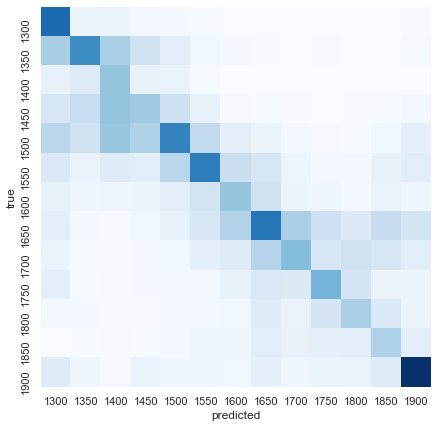

In [33]:
sgd_predict = sgd.predict(X_val)
print("Number of train examples:", len(train_loader) * BATCH_SIZE )
print(f1_score(y_val, sgd_predict, average="weighted"), mean_squared_error(y_val, sgd_predict), sep="\n")

cmat = confusion_matrix(y_val, sgd_predict)
plt.figure(figsize=(7,7))
sns.heatmap(
    cmat / np.sum(cmat, axis=1),
    annot=False, cbar=False,
    xticklabels=[1300 + i*50 for i in range(13)],
    yticklabels=[1300 + i*50 for i in range(13)],
    cmap="Blues")
plt.ylabel("true")
plt.xlabel("predicted")
plt.show()

## Используем SVM

In [34]:
def distance(true, predicted):
    result = 0.0
    for t, p in zip(true, predicted):
        if t == p:
            continue
        elif abs(t - p) < 3:
            result += 0.5
        else:
            result += 1.0
    return result / len(true)

In [35]:
linear_svc = LinearSVC(verbose=2, max_iter=1000)
linear_svc.fit(X_train, y_train)

[LibLinear]

C:\ProgramData\Anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(verbose=2)

Number of train examples: 18735
0.321308546297597
8.951321056845476
0.4910328262610088


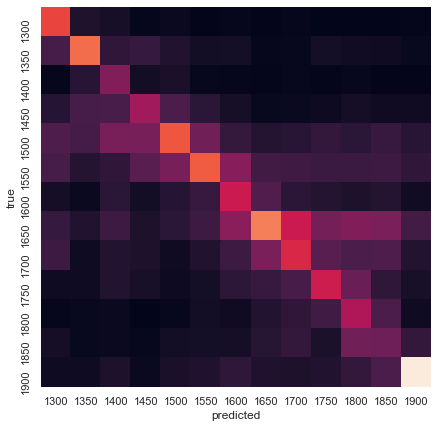

In [36]:
svc_predict = linear_svc.predict(X_test)
print("Number of train examples:", len(train_loader) * BATCH_SIZE )
print(f1_score(y_test, svc_predict, average="weighted"), mean_squared_error(y_test, svc_predict),
      distance(y_test, svc_predict), sep="\n")

cmat = confusion_matrix(y_test, svc_predict)
plt.figure(figsize=(7,7))
sns.heatmap(
    cmat / np.sum(cmat, axis=1),
    annot=False, cbar=False,
    xticklabels=[1300 + i*50 for i in range(13)],
    yticklabels=[1300 + i*50 for i in range(13)])
plt.ylabel("true")
plt.xlabel("predicted")

if ENABLE_PCA:
    plt.gcf().savefig("results/" + NAME + "_PCA_" + str(PCA_COMPONENTS) + ".svg")
else:
    plt.gcf().savefig("results/" + NAME + ".svg")

13


<ipython-input-37-be8cdb09c21b>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([i for i in range(1300, 2000, 100)])


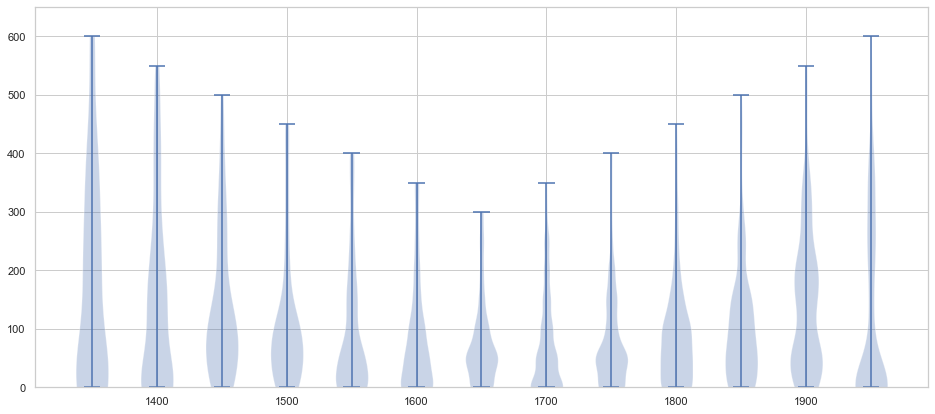

{'whiskers': [<matplotlib.lines.Line2D at 0x185d1958d00>,
 'caps': [<matplotlib.lines.Line2D at 0x185d1965400>,
 'boxes': [<matplotlib.lines.Line2D at 0x185d19589a0>],
 'medians': [<matplotlib.lines.Line2D at 0x185d1965ac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x185d1965e20>],
 'means': []}

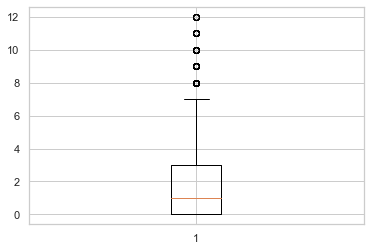

In [37]:
from sklearn.metrics import f1_score, mean_squared_error, mean_squared_log_error, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
sns.set()
sns.set_style("whitegrid")


plt.figure(figsize=(16,7))

error = np.abs(y_test-svc_predict)
errors_by_classes = []
classes = list(range(NUM_CLASSES))
for i in range(NUM_CLASSES):
    index_mask = np.where(y_test==i)
    errors_by_classes.append(
        np.power(np.power(y_test.values[index_mask]-svc_predict[index_mask], 2), 1/2) * 50
    )
print(len(errors_by_classes))
plt.violinplot(dataset=errors_by_classes)
plt.gca().set_xticklabels([i for i in range(1300, 2000, 100)])
plt.gca().set_ylim(0, 13*50+0.75)
plt.gcf().savefig("results/" + NAME + "_PCA_" + str(PCA_COMPONENTS) + "_violin.svg")
plt.show()
plt.boxplot(error)
